## Part 1. Exploratory Data Analysis

Task: The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import seaborn as sns



### Load 'logins data'

In [3]:
df = pd.read_json('logins.json')

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [6]:
df.shape

(93142, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


###### no null values observed from above

#### Step 1: Aggregate these login counts based on 15 minute time intervals.

In [9]:
# following the downsampling technique
df.set_index('login_time', inplace=True)


In [10]:
df['count'] = 1


In [11]:
df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [12]:
df.sort_index(inplace=True)
df_agg = df.resample("15min").sum()

In [13]:
df_agg.shape

(9788, 1)

In [14]:
df_agg.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0, 0.5, 'User Login Count')

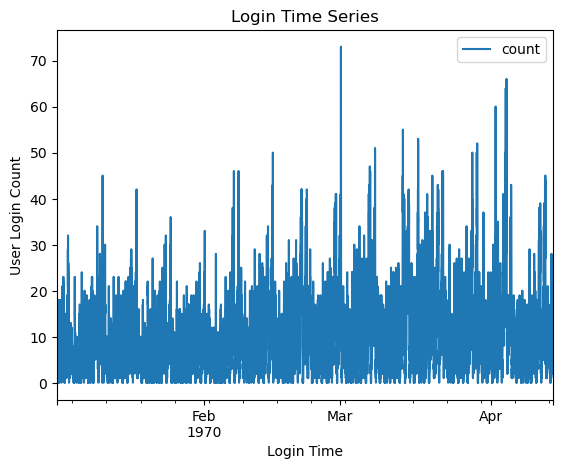

In [17]:
df_agg.plot()
plt.title('Login Time Series')
plt.xlabel('Login Time')
plt.ylabel('User Login Count')

There is lot of noise in this above graph. We can reduce it by converting times series to hourly, daily, weekly, and monthly 

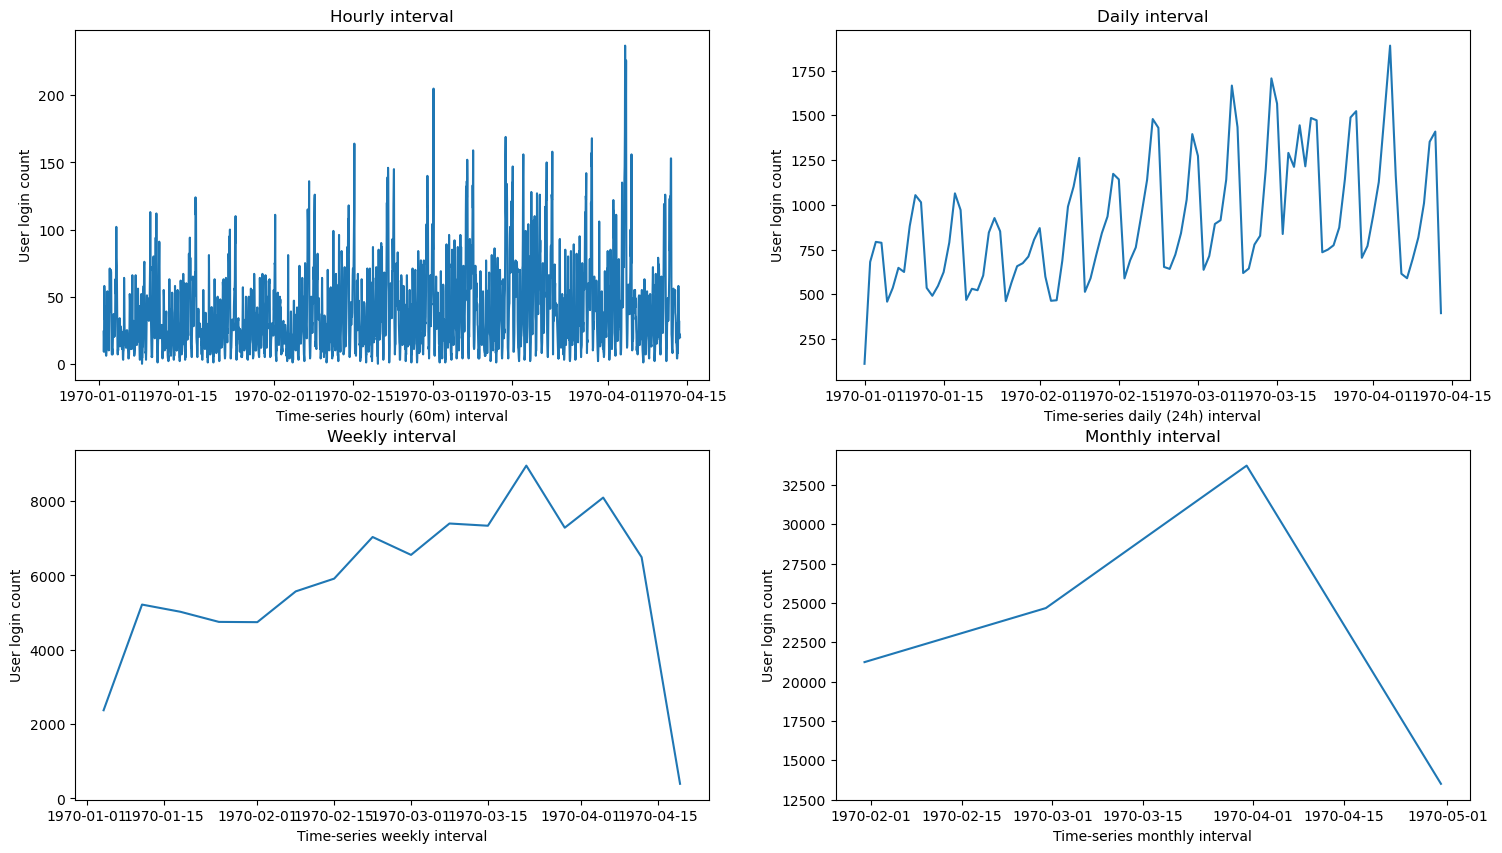

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(df.resample('60T').sum());
ax1.set(xlabel='Time-series hourly (60m) interval', ylabel='User login count', title='Hourly interval');

# Daily interval
ax2.plot(df.resample('D').sum());
ax2.set(xlabel='Time-series daily (24h) interval', ylabel='User login count', title='Daily interval');

# Weekly interval
ax3.plot(df.resample('W').sum());
ax3.set(xlabel='Time-series weekly interval', ylabel='User login count', title='Weekly interval');

# Monthly interval
ax4.plot(df.resample('M').sum());
ax4.set(xlabel='Time-series monthly interval', ylabel='User login count', title='Monthly interval');

I will go with Daily time series for further analysis 

Text(0.5, 1.0, 'Daily time series with date range(1970-01-01 - 1970-01-02)')

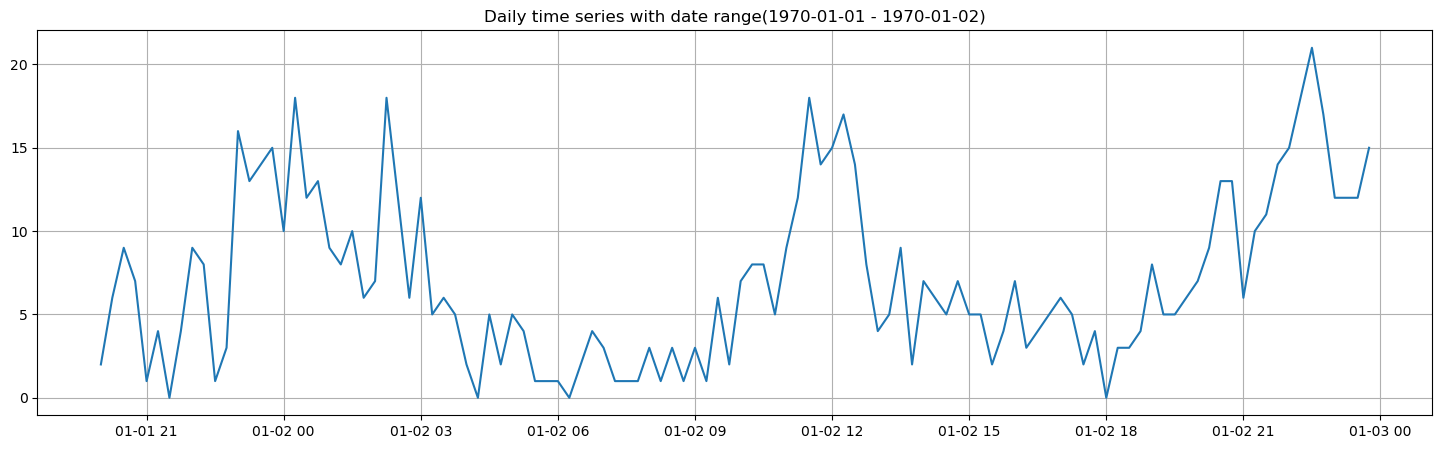

In [25]:
plt.figure(figsize=(18,5));
plt.plot(df_agg.loc['1970-01-01':'1970-01-02' ])
plt.grid()
plt.title("Daily time series with date range(1970-01-01 - 1970-01-02)")

I observe that login counts are high before noon time and one hour before midnight

In [22]:
df_agg.loc['1970-01-01':'1970-01-02' ]

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-01-02 22:45:00,17
1970-01-02 23:00:00,12
1970-01-02 23:15:00,12


In [24]:
df_agg.loc['1970-01-01':'1970-01-02' ].value_counts()

count
5        13
1        11
4         9
6         9
2         8
3         8
7         7
12        7
8         6
9         6
0         4
15        4
18        4
13        4
14        4
10        3
17        2
16        1
11        1
21        1
dtype: int64

### Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.<br/>
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

<font color='blue'>We can keep the record of cars crossing tht toll bridge and make the reimbursement process faster. Make a toll pass may be at a lower price which drivers have to pay annually. Whoever has a toll pass and stick it on their car and some reader will read the pass and wil let them enter and exit the toll.</font> 

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:<br />
<br />a) how you will implement the experiment

<font color='blue'>
If sample size is greater than  30 drivers then z-test else t-test. Compare number of driver bridge crossings.

Null Hypothesis: No difference in driver bridge crossings, after toll reimbursement experiment
Alternative Hypothesis : Increase in driver bridge crossings, after toll reimbursement experiment.

Calculate z-score of average frequency of drivers serving both cities, post-reimbursement experiment. Set alpha to be 0.05. Determine if z-score's p-value falls below this significance threshold.

If p-value is less than  0.05, then we rejct null hypothesis and accept or fail to reject alternative hypothesis, indicating that this toll reimbursement policy was a success.

However, the caveat is that 
 significance levels are set arbitrarly and p-values fluctuate depending on sample size. So depending on how wide of a margin the post-reimbursement increase is, our experiment could either support or reject the policy.

As a result, I recommend only considering the policy a success if the margin is wide enough (and p-value far below 0.05) that it is obvious that a significant post-reimbursement increase has occurred even in the midst of the aforementioned fluctuations.</font>

### Part 3 ‐ Predictive modeling


Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

## Load 'ultimate_data_challenge.json' data

In [26]:
df_user = pd.read_json('ultimate_data_challenge.json')

In [27]:
df_user.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [28]:
df_user.shape

(50000, 12)

In [29]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [30]:
df_user.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [31]:
df_user[df_user.phone.isna()==True]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
134,King's Landing,0,2014-01-10,5.0,1.00,2014-06-11,None,0.0,False,100.0,2.88,5.0
176,Astapor,0,2014-01-28,5.0,1.00,2014-03-18,None,0.0,False,100.0,20.32,5.0
320,Astapor,1,2014-01-08,5.0,1.00,2014-01-09,None,0.0,False,100.0,31.01,5.0
349,Winterfell,1,2014-01-06,3.3,1.00,2014-06-22,None,0.0,True,33.3,6.03,5.0
389,King's Landing,5,2014-01-26,4.9,1.02,2014-07-01,None,3.0,False,66.7,3.08,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
49587,Winterfell,1,2014-01-17,5.0,1.00,2014-01-19,None,0.0,True,0.0,1.15,3.0
49627,Astapor,6,2014-01-05,5.0,1.00,2014-01-25,None,0.0,True,33.3,3.10,4.5
49666,Winterfell,2,2014-01-22,NaN,1.00,2014-01-23,None,0.0,True,100.0,0.73,5.0
49825,Astapor,0,2014-01-25,5.0,1.00,2014-03-10,None,0.0,True,50.0,5.82,5.0


In [32]:
#drop rows with no phone information
df_user = df_user.drop(df_user[df_user.phone.isna()==True].index,axis=0)

In [33]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [34]:
# fill missing values with mean rating for avg_rating_of_driver and avg_rating_by_driver
df_user.avg_rating_by_driver.fillna(df_user.avg_rating_by_driver.mean(),inplace=True)
df_user.avg_rating_of_driver.fillna(df_user.avg_rating_of_driver.mean(),inplace=True)

In [35]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.


In [36]:
#last_trip_date has a stype of object. we need to convert that to date_time
df_user['last_trip_date'] = pd.to_datetime(df_user['last_trip_date'])

In [37]:
df_user['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [38]:
#set current date 
current_date = df_user['last_trip_date'].max()

#find if user qualifies as active
df_user['active'] = df_user['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df_user.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [39]:
#how many are active?
df_user['active'].value_counts()

0    30933
1    18671
Name: active, dtype: int64

In [48]:
res = (df_user['active'].values == 1).sum()
res

18671

In [49]:
len(df_user)

49604

In [50]:
#percentage of drivers who are active at the end of the six month.
res/len(df_user)*100

37.640109668575114

###  Random Forest Classifier 

In [51]:
#create dummy variables for categorical features
df_features = pd.get_dummies(df_user,columns=['city','phone','ultimate_black_user'])
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [52]:
#set target and drop columns which are no use for us
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

In [53]:
df_features.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [55]:
#scale data
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)

In [56]:
#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)

In [62]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((39683, 14), (9921, 14), (39683,), (9921,))

In [57]:
#build random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [58]:
rf.score(X_test,y_test)

0.7526459026307832

In [59]:
cv_score=cross_val_score(rf,X_test,np.ravel(y_test),cv=5)
print('Mean Cross Validated Score:',np.mean(cv_score))

Mean Cross Validated Score: 0.7469001889168766


In [60]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.299602
4,weekday_pct,0.132978
6,avg_rating_by_driver,0.113878
1,avg_rating_of_driver,0.082350
0,trips_in_first_30_days,0.080440
3,surge_pct,0.077764
2,avg_surge,0.066603
8,city_King's Landing,0.046414
10,phone_Android,0.019863
11,phone_iPhone,0.019487


City, phone type, and ultimate black user stats are all relatively unimportant for the model compared to average distance driven, weekday percentage, and the rating given to the passenger by the driver

In [61]:
#generate confusion matrix
confusion_matrix(y_test,y_pred)

array([[4971, 1229],
       [1225, 2496]], dtype=int64)

In [70]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6200
           1       0.67      0.67      0.67      3721

    accuracy                           0.75      9921
   macro avg       0.74      0.74      0.74      9921
weighted avg       0.75      0.75      0.75      9921



we can see the accuracy more than 75.

### Logistc Regression with Grid Search

In [64]:
#initialize model
logit = LogisticRegression(solver='lbfgs')
#set parameter grid
param_grid = {'C':np.arange(0.5,5.1,0.1)}
#instantiate and fit grid search object
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])})

In [65]:
grid.best_estimator_.C

3.999999999999999

In [66]:
#find coefficients from Logistic Regression
logit_coef = LogisticRegression(C=grid.best_estimator_.C)
logit_coef.fit(X_train,y_train)
df_coef = pd.DataFrame(zip(list(df_features.columns),logit_coef.coef_[0]),index=range(df_features.columns.shape[0]),columns=['feature','coefficient'])
df_coef

,feature,coefficient
0,trips_in_first_30_days,0.113437
1,avg_rating_of_driver,-0.329943
2,avg_surge,2.509991
3,surge_pct,-1.430471
4,weekday_pct,-0.242662
5,avg_dist,0.157505
6,avg_rating_by_driver,-1.345031
7,city_Astapor,-0.770335
8,city_King's Landing,1.114930
9,city_Winterfell,-0.249246


In [67]:
print(np.mean(cross_val_score(grid,X_test,np.ravel(y_test),cv=5)))

0.7420622917851629


We have not gained any advantage using Logistic Regression for our classifier, the models perform almost identically.

In conclusion, we have extracted very valuable information from this dataset.

First, we have built a predictive model with 75% accuracy, that will be useful for future prediction.

Secondly, the insights from the model are arguably more important and lucrative for the company. Random Forest has given us the most important features and Logistic Regression shows us the effect of the features through the coefficients. Taking the three most important features, we can see the following effects on the "activity" of a rider after 6 months.

Average distance: This one is tricky because while our logistic regression model shows that an increase in average distance per trip in the first 30 days increases our chances of being an active user, interestingly, the mean avg_dist is larger for inactive riders than for active. Due to this ambiguity in the data, it may not be advisable to try to increase the distance of trips taken in the first 30 days.

weekday percentage: The chance of being an active user decrease as the percentage of week day use goes up. From this we can see that encouraging people to use the app on the weekend will be beneficial for the company revenue.

average rating by driver: For this feature, there is a decreased likelihood of being an active user as your rating goes up.

trips in the first 30 days: As the number of trips in the first 30 days increases, so does the chance that a rider is active after 6 months.

Based on these insights gained from the model, there are several recomendations for the company.

Offer incentives to riders to use the app on the weekends Incentivize riders to take more trips during their first 30 days on the app Encourage drivers not to artificially inflate the ratings they give to users, especially if the driver can tell that they've never done this before. Following these guidelines will increase the chances of more active users in the long term, and therefore more revenue for the company.